In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import preprocess_input
import os
import pandas as pd
import cv2

In [60]:
input_shape = (128, 128, 3)  # Standard VGG16 RGB input
batch_size = 64
num_epochs = 50 # Set a higher number of epochs, EarlyStopping will handle the actual stop

In [4]:
preprocessed_path = r"D:\FUCK!!\Pattern\Project\notebooks\preprocessed_RGB_images"

# “val_dir” is the root of your test/validation folder
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

print("Setting up Training Generator...")
train_generator = train_datagen.flow_from_directory(
    os.path.join(preprocessed_path, 'train'),
    target_size=input_shape[:2], # Use (224, 224)
    batch_size=batch_size,
    class_mode='sparse',         # Use sparse for sparse_categorical_crossentropy
    color_mode='rgb',
    shuffle=True             # Ensure images are loaded as RGB
)
print(f"Found {train_generator.samples} images belonging to {train_generator.num_classes} classes in training set.")

print("\nSetting up Validation Generator...")
val_generator = train_datagen.flow_from_directory(
    os.path.join(preprocessed_path, 'val'),
    target_size=input_shape[:2], # Use (224, 224)
    batch_size=batch_size,
    class_mode='sparse',         # Use sparse for sparse_categorical_crossentropy
    color_mode='rgb',            # Ensure images are loaded as RGB
    shuffle=False                # No need to shuffle validation data
)
print(f"Found {val_generator.samples} images belonging to {val_generator.num_classes} classes in validation set.")

print("\nSetting up Testing Generator...")
test_generator = train_datagen.flow_from_directory(
    os.path.join(preprocessed_path, 'test'),
    target_size=input_shape[:2], # Use (224, 224)
    batch_size=batch_size,
    class_mode='sparse',         # Use sparse for sparse_categorical_crossentropy
    color_mode='rgb',            # Ensure images are loaded as RGB
    shuffle=False                # No need to shuffle validation data
)
print(f"Found {test_generator.samples} images belonging to {test_generator.num_classes} classes in validation set.")


Setting up Training Generator...
Found 30580 images belonging to 10 classes.
Found 30580 images belonging to 10 classes in training set.

Setting up Validation Generator...
Found 328 images belonging to 10 classes.
Found 328 images belonging to 10 classes in validation set.

Setting up Testing Generator...
Found 328 images belonging to 10 classes.
Found 328 images belonging to 10 classes in validation set.


In [70]:
base = applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape   
)

# 2) Freeze early blocks, fine-tune later ones
for layer in base.layers[:-13]:
    layer.trainable = False
print(f"RN50 base model loaded. Trainable: {base.trainable}")


# Create the new model head
RN50_model = models.Sequential([
    base,
    layers.GlobalAveragePooling2D(name='global_avg_pool'),
    layers.Dense(512, activation='relu', name='fc1'),
    layers.BatchNormalization(),
    layers.Dropout(0.75, name='dropout_1'), # Dropout for regularization
    layers.Dense(256, activation='relu', name='fc2'),
    layers.BatchNormalization(),
    layers.Dropout(0.75, name='dropout_2'), # Dropout for regularization
    layers.Dense(128, activation='relu', name='fc3'),
    layers.BatchNormalization(),
    layers.Dropout(0.75, name='dropout_3'), # Dropout for regularization
    layers.Dense(10, activation='softmax', name='predictions') # Output layer
], name="VGG16_Transfer_Learning")

# --- Compile Model ---
# Use Adam optimizer with a specific, smaller learning rate
optimizer = Adam(learning_rate=0.0001) # 0.0001 learning rate

RN50_model.compile(optimizer=optimizer,
                    loss='sparse_categorical_crossentropy', # Use sparse CE with class_mode='sparse'
                    metrics=['accuracy'])

print("\nModel Summary:")
RN50_model.summary()

RN50 base model loaded. Trainable: True

Model Summary:


Model: "VGG16_Transfer_Learning"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc3 (Dense)                     │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,805,898 (94.63 MB)

 Trainable params: 5,686,154 (21.69 MB)

 Non-trainable params: 19,119,744 (72.94 MB)

In [23]:
# --- Define Callbacks ---
# Early stopping to prevent overfitting and stop training when val_loss stops improving
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    verbose=1,
    restore_best_weights=True # Restore model weights from the epoch with the best val_loss
)

# Model checkpoint to save the best model found during training
model_checkpoint = ModelCheckpoint(
    filepath='best_RN50_model.keras', # File path to save the model
    monitor='val_loss',
    save_best_only=True, # Only save a model if `val_loss` has improved
    verbose=1
)

In [61]:
# 4. Train the “head” on your feature vectors
print(f"\nStarting training for up to {num_epochs} epochs (head only)...")
history = RN50_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size, # Ensure steps cover the dataset
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size, # Ensure steps cover the dataset
    epochs=num_epochs,
    callbacks=[early_stopping, model_checkpoint] # Add the callbacks
)
print("\nTraining finished.")


Starting training for up to 50 epochs (head only)...
Epoch 1/50
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 600ms/step - accuracy: 0.1217 - loss: 4.2602
Epoch 1: val_loss did not improve from 0.71335
477/477 ━━━━━━━━━━━━━━━━━━━━ 297s 609ms/step - accuracy: 0.1218 - loss: 4.2595 - val_accuracy: 0.5406 - val_loss: 1.3360
Epoch 2/50
  1/477 ━━━━━━━━━━━━━━━━━━━━ 4:35 578ms/step - accuracy: 0.1562 - loss: 3.5777

c:\Users\omarn\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss did not improve from 0.71335
477/477 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1562 - loss: 3.5777 - val_accuracy: 0.5469 - val_loss: 1.3332
Epoch 3/50
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.2272 - loss: 2.9753
Epoch 3: val_loss did not improve from 0.71335
477/477 ━━━━━━━━━━━━━━━━━━━━ 272s 571ms/step - accuracy: 0.2272 - loss: 2.9748 - val_accuracy: 0.6313 - val_loss: 1.0363
Epoch 4/50
  1/477 ━━━━━━━━━━━━━━━━━━━━ 4:25 558ms/step - accuracy: 0.2969 - loss: 2.1764
Epoch 4: val_loss did not improve from 0.71335
477/477 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.2969 - loss: 2.1764 - val_accuracy: 0.6313 - val_loss: 1.0356
Epoch 5/50
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - accuracy: 0.3503 - loss: 2.1228
Epoch 5: val_loss did not improve from 0.71335
477/477 ━━━━━━━━━━━━━━━━━━━━ 266s 558ms/step - accuracy: 0.3503 - loss: 2.1226 - val_accuracy: 0.6875 - val_loss: 0.9263
Epoch 6/50
  1/477 ━━━━━━━━━━━━━━━━━━━━ 4:23 554ms/step - accuracy: 0

In [62]:
from tensorflow.keras.models import load_model
model = load_model(r'D:\FUCK!!\Pattern\Project\Models\best_RN50_model.keras')

In [63]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix

# 1) Prepare a “pure” test generator (no augmentation, only the same preprocessing)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_gen = test_datagen.flow_from_directory(
    directory=r'D:\FUCK!!\Pattern\Project\notebooks\preprocessed_RGB_images\test',    # point this to your test‐folder 
    target_size=input_shape[:2],           # e.g. (224, 224)
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False                           # important! so labels/preds align
)

Found 328 images belonging to 10 classes.


In [64]:
# 0) Clear any old graphs / functions
tf.keras.backend.clear_session()

# 1) Reload your .keras model
model = load_model(r'D:\FUCK!!\Pattern\Project\Models\best_RN50_model.keras')

# 2) Re-compile it with the correct loss and metrics, running eagerly
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
    run_eagerly=True    # ← this disables the tf.function wrapping
)

# 3) Now evaluate on your test generator (no need to pass steps)
loss, acc = model.evaluate(test_gen, verbose=1)
print(f"\nTest loss: {loss:.4f} — Test accuracy: {acc:.4f}")

c:\Users\omarn\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7890 - loss: 0.6127

Test loss: 0.7700 — Test accuracy: 0.7470


In [65]:
# 3) (Optional) Get per‐class metrics
#    - Predict class probabilities
steps = int(np.ceil(test_gen.samples / batch_size))
pred_probs = model.predict(
    test_gen,
    steps = steps,
    verbose=1
)
#    - Turn them into predicted class indices
pred_idxs = np.argmax(pred_probs, axis=1)
true_idxs = test_gen.classes
labels   = list(test_gen.class_indices.keys())

#    - Classification report
print("\nClassification Report:\n")
print(classification_report(true_idxs, pred_idxs, target_names=labels))



6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 830ms/step

Classification Report:

                                  precision    recall  f1-score   support

         Achaemenid architecture       0.94      0.96      0.95        48
American Foursquare architecture       0.85      0.76      0.80        45
        American craftsman style       0.52      0.64      0.57        25
   Ancient Egyptian architecture       0.95      0.87      0.91        23
           Art Deco architecture       0.74      0.57      0.64        30
        Art Nouveau architecture       0.71      0.80      0.75        25
            Baroque architecture       0.64      0.64      0.64        33
            Bauhaus architecture       0.86      0.76      0.81        33
         Beaux-Arts architecture       0.51      0.80      0.62        35
          Byzantine architecture       0.95      0.58      0.72        31

                        accuracy                           0.75       328
                       macro avg       0.77   

In [69]:
#    - Classification report
print("confusion Matrix:\n")
print(confusion_matrix(true_idxs, pred_idxs))

confusion Matrix:

[[46  0  0  1  0  0  0  0  1  0]
 [ 0 34 10  0  0  0  0  0  1  0]
 [ 1  6 16  0  0  0  0  0  2  0]
 [ 2  0  0 20  0  0  0  0  1  0]
 [ 0  0  1  0 17  1  3  3  5  0]
 [ 0  0  0  0  0 20  1  0  4  0]
 [ 0  0  0  0  1  5 21  0  5  1]
 [ 0  0  1  0  5  0  0 25  2  0]
 [ 0  0  2  0  0  2  2  1 28  0]
 [ 0  0  1  0  0  0  6  0  6 18]]


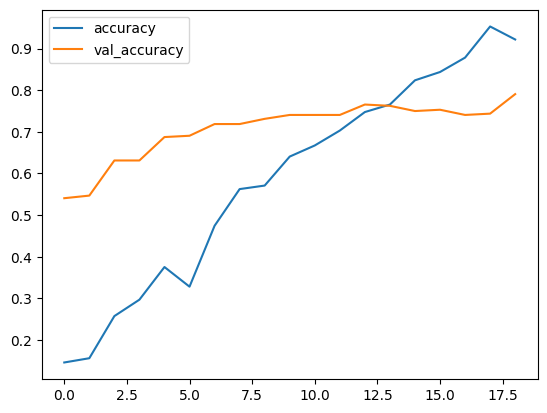

In [66]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend(); plt.show()

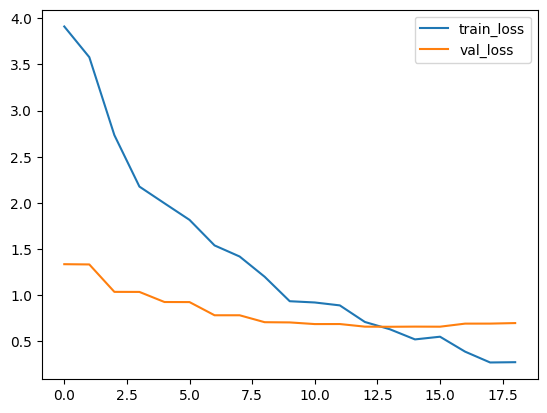

In [67]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.show()
